### Abstract

This notebook showcases on how to build a [GAN](https://arxiv.org/pdf/1406.2661.pdf) (Generative Adversary Network) with [the pytorch framwork](http://pytorch.org/). It is inspired and adapted from [the blog post of medium.com](https://medium.com/@devnag/generative-adversarial-networks-gans-in-50-lines-of-code-pytorch-e81b79659e3f#.sch4xgsa9).


In [164]:
# Generative Adversarial Networks (GAN) example in PyTorch.
# See related blog post at 
# https://medium.com/@devnag/generative-adversarial-networks-gans-in-50-lines-of-code-pytorch-e81b79659e3f#.sch4xgsa9
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15,6
rcParams['figure.dpi'] = 100
rcParams['savefig.dpi'] = 100

In [442]:
# ##### DATA: Target data and generator input data

dtype = torch.cuda.FloatTensor
#dtype = torch.FloatTensor


def get_distribution_sampler(mu, sigma):
    return lambda n: torch.Tensor(np.random.normal(mu, sigma, (1, n)))  # Gaussian

def get_generator_input_sampler():
    return lambda m, n: torch.rand(m, n)  # Uniform-dist data into generator, _NOT_ Gaussian


In [259]:
# ##### MODELS: Generator model and discriminator model
#%time

class Generator(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Generator, self).__init__()
        self.map1 = nn.Linear(input_size, hidden_size)
        self.map2 = nn.Linear(hidden_size, hidden_size)
        self.map3 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = F.elu(self.map1(x))
        x = F.sigmoid(self.map2(x))
        return self.map3(x)

class Discriminator(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Discriminator, self).__init__()
        self.map1 = nn.Linear(input_size, hidden_size)
        self.map2 = nn.Linear(hidden_size, hidden_size)
        self.map3 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = F.elu(self.map1(x))
        x = F.elu(self.map2(x))
        return F.sigmoid(self.map3(x))

def extract(v):
    return v.data.storage().tolist()


import scipy.stats as statslib

def stats(d):
    k2, p = statslib.normaltest(d)
    return [np.mean(d), np.std(d), k2, p]


def decorate_with_diffs(data, exponent):
    mean = torch.mean(data.data, 1, keepdim=True)
    mean_broadcast = torch.mul(torch.ones(data.size()), mean.tolist()[0][0])
    diffs = torch.pow(data - Variable(mean_broadcast).cuda(), exponent)
    return torch.cat([data, diffs], 1)


In [260]:
# ### Uncomment only one of these
#(name, preprocess, d_input_func) = ("Raw data", lambda data: data, lambda x: x)
(name, preprocess, d_input_func) = ("Data and variances", lambda data: decorate_with_diffs(data, 2.0), lambda x: x * 2)

print("Using data [%s]" % (name))

Using data [Data and variances]


In [429]:
# Data params
data_mean = 4
data_stddev = 1.25

# Model params
g_input_size = 1     # Random noise dimension coming into generator, per output vector
g_hidden_size = 50   # Generator complexity
g_output_size = 1    # size of generated output vector

d_input_size = 100   # Minibatch size - cardinality of distributions
d_hidden_size = 50   # Discriminator complexity
d_output_size = 1    # Single dimension for 'real' vs. 'fake'
minibatch_size = d_input_size

d_learning_rate = 2e-4  # 2e-4
g_learning_rate = 2e-4
optim_betas = (0.9, 0.999)

num_epochs = 20000
#num_epochs = 30000

print_interval = 200

d_steps = 1  # 'k' steps in the original GAN paper. Can put the discriminator on higher training freq than generator
g_steps = 1

In [430]:
d_sampler = get_distribution_sampler(data_mean, data_stddev)
gi_sampler = get_generator_input_sampler()

G = Generator(input_size=g_input_size, hidden_size=g_hidden_size, output_size=g_output_size)
D = Discriminator(input_size=d_input_func(d_input_size), hidden_size=d_hidden_size, output_size=d_output_size)

# Binary cross entropy: http://pytorch.org/docs/nn.html#bceloss
criterion = nn.BCELoss()

d_optimizer = optim.Adam(D.parameters(), lr=d_learning_rate, betas=optim_betas)
g_optimizer = optim.Adam(G.parameters(), lr=g_learning_rate, betas=optim_betas)

Run the networks on GPU

In [431]:
G = G.cuda()
D = D.cuda()
criterion = criterion.cuda()

In [432]:
d_real_error_list = []
d_fake_error_list = []
g_error_list = []

d_real_data_stat_list = []
d_fake_data_stat_list = []

g_pvalue_threshold = 0.8

def to_numpy(tensor):
    return tensor.data.cpu().numpy()


def plot_snapshot_kde(real_data, fake_data, label):
    fig, ax = plt.subplots(figsize=(15, 6))

    legend = "Mean:" + str(real_data.mean()) + \
             "    Std:" + str(real_data.std())

    sns.distplot(real_data, kde=True, hist=False, axlabel='value', label='real sample', ax=ax)
    sns.distplot(fake_data, kde=True, hist=False, color='r', label='fake sample', ax=ax)
    
    ax.set_xlim(-1, 9)
    ax.set_ylim(0, 0.4)
    ax.annotate(label, xy=(-0.5, 0.35), xytext=(-0.5, 0.35))
    
    ax.set_ylabel("Kernel Density Estimation %")
    _ = ax.legend()
    
    return fig


def train_GAN(num_epochs):
    '''
    '''
    image_count = 1
    
    for epoch in range(num_epochs):
        for d_index in range(d_steps):
            # 1. Train D on real+fake
            D.zero_grad()

            #  1A: Train D on real
            d_real_data = Variable(d_sampler(d_input_size)).cuda()
        
            d_real_decision = D(preprocess(d_real_data))
            d_real_error = criterion(d_real_decision, Variable(torch.ones(1).cuda()))  # ones = true
            # compute/store gradients, but don't change params
            d_real_error.backward()
            
            #  1B: Train D on fake
            d_gen_input = Variable(gi_sampler(minibatch_size, g_input_size)).cuda()
            d_fake_data = G(d_gen_input).detach()  # detach to avoid training G on these labels
            d_fake_decision = D(preprocess(d_fake_data.t()))
            d_fake_error = criterion(d_fake_decision, Variable(torch.zeros(1)).cuda()).cuda()  # zeros = fake
            d_fake_error.backward()
            # Only optimizes D's parameters; changes based on stored gradients from backward()
            d_optimizer.step()  
            
        for g_index in range(g_steps):
            # 2. Train G on D's response (but DO NOT train D on these labels)
            G.zero_grad()

            gen_input = Variable(gi_sampler(minibatch_size, g_input_size)).cuda()
            g_fake_data = G(gen_input)
            dg_fake_decision = D(preprocess(g_fake_data.t()))
            # we want to fool, so pretend it's all genuine
            g_error = criterion(dg_fake_decision, Variable(torch.ones(1)).cuda()) 
            
            g_error.backward()
            g_optimizer.step()  # Only optimizes G's parameters

        
        d_real_error_list.append(extract(d_real_error)[0])
        d_fake_error_list.append(extract(d_fake_error)[0])
        g_error_list.append(extract(g_error)[0])
        d_real_data_stat_list.append(stats(extract(d_real_data)))
        d_fake_data_stat_list.append(stats(extract(d_fake_data)))
        
        
        # plot the training snapshot
        if epoch % 100 == 0:
            label_str = "epoch: %s / %s \nD on counterfeit: %f" % (str(epoch), str(num_epochs), extract(d_fake_decision)[0])
            plot_fig = plot_snapshot_kde(to_numpy(d_real_data), to_numpy(d_fake_data), label_str)
            # save the figure to a file as the snapshot for this epoch
            plot_fig.savefig('gan_%05d.png' % image_count, dpi=300, format='png')
            image_count = image_count + 1
            # do not show it in this notebook
            plt.close(plot_fig)
        
        '''
        if (d_fake_data_stat_list[-1][-1] >= g_pvalue_threshold and  
            abs(d_fake_data_stat_list[-1][0] - 4) < 0.5 and 
            abs(d_fake_data_stat_list[-1][1] - 1.25) < 0.2):
            
            print('============ Early Exit =============')
            print("%s: D: %s/%s G: %s (Real: %s, Fake: %s) " % (epoch,
                                                                d_real_error_list[-1],
                                                                d_fake_error_list[-1],
                                                                g_error_list[-1],
                                                                d_real_data_stat_list[-1],
                                                                d_fake_data_stat_list[-1]))
            break
        '''
        
        if epoch % print_interval == 0:
            print("%s: D: %s/%s G: %s (Real: %s, Fake: %s) " % (epoch,
                                                                d_real_error_list[-1],
                                                                d_fake_error_list[-1],
                                                                g_error_list[-1],
                                                                d_real_data_stat_list[-1],
                                                                d_fake_data_stat_list[-1]))

In [441]:
%%time

num_epochs = 20000

print('Total epochs:', num_epochs)

#train_GAN(num_epochs)


Total epochs: 20000
CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 590 µs


### Training Process Visualization

In [304]:

def get_metadata():
    
    df_metadata = pd.DataFrame()
    
    df_metadata['epoch'] = range(1, len(d_real_error_list)+1)
    df_metadata['d_real_error'] = d_real_error_list
    df_metadata['d_fake_error'] = d_fake_error_list
    df_metadata['g_error'] = g_error_list
    
    df_real_data_stat = pd.DataFrame(d_real_data_stat_list,
        columns=['d_real_data_mean', 'd_real_data_std', 'd_real_data_stats', 'd_real_data_pvalue'])
    
    df_fake_data_stat = pd.DataFrame(d_fake_data_stat_list,
        columns=['d_fake_data_mean', 'd_fake_data_std', 'd_fake_data_stats', 'd_fake_data_pvalue'])
    
    df_metadata = pd.concat([df_metadata, df_real_data_stat, df_fake_data_stat], axis=1)
    
    return df_metadata


df_metadata = get_metadata()

#df_metadata.to_csv('GAN_pytorch_metadata_epoch_40000.csv', index=False)

df_metadata.head()

,epoch,d_real_error,d_fake_error,g_error,d_real_data_mean,d_real_data_std,d_real_data_stats,d_real_data_pvalue,d_fake_data_mean,d_fake_data_std,d_fake_data_stats,d_fake_data_pvalue
0,1,0.629279,0.640220,0.748280,3.765433,1.244518,1.504574,0.471287,-0.008228,0.009629,33.497657,5.322016e-08
1,2,0.657166,0.640566,0.749013,4.051946,1.256638,2.055955,0.357730,-0.016053,0.008964,21.935387,1.725009e-05
2,3,0.640449,0.639116,0.748909,4.005394,1.143248,0.140633,0.932099,-0.021209,0.009322,18.419791,1.000445e-04
3,4,0.827049,0.640096,0.750607,4.104839,1.168614,1.582831,0.453203,-0.019558,0.010939,66.125583,4.375342e-15
4,5,0.549504,0.640139,0.750620,4.176191,1.282430,0.300081,0.860673,-0.013743,0.011224,43.432962,3.703839e-10


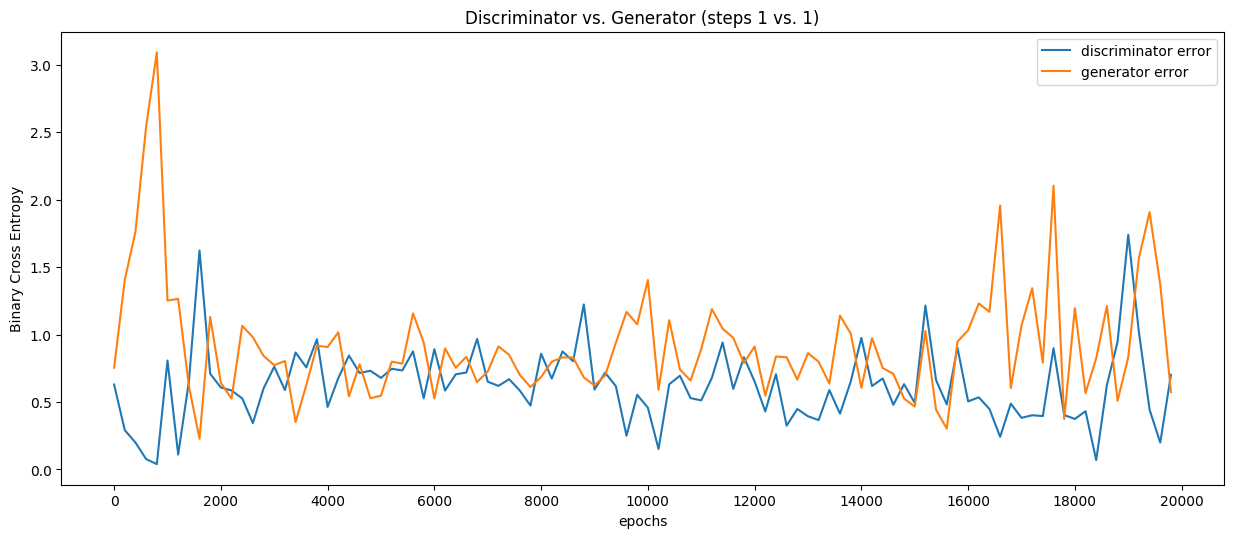

In [434]:

fig = plt.figure()
    
plot_samples = range(0, len(g_error_list), 200)

#plt.scatter(x=plot_samples, y=pd.DataFrame(g_error_list).iloc[plot_samples], linewidths=0.1)

plt.plot(plot_samples, pd.DataFrame(d_fake_error_list).iloc[plot_samples], label='discriminator error')
plt.plot(plot_samples, pd.DataFrame(g_error_list).iloc[plot_samples], label='generator error')

plt.title("Discriminator vs. Generator (steps 1 vs. 1)")

plt.xlabel('epochs')
plt.ylabel('Binary Cross Entropy')
plt.xticks(np.arange(0, len(g_error_list)+1, 2000))
plt.legend()
plt.show()

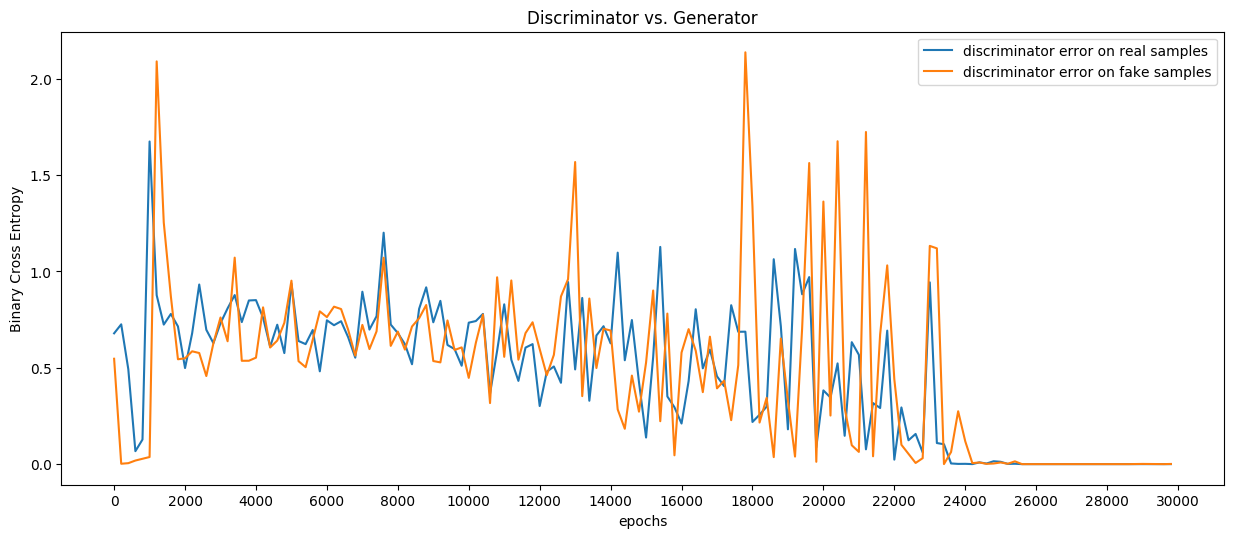

In [414]:

fig = plt.figure()
    
plot_samples = range(0, len(g_error_list), 200)

#plt.scatter(x=plot_samples, y=pd.DataFrame(g_error_list).iloc[plot_samples], linewidths=0.1)

plt.plot(plot_samples, pd.DataFrame(d_fake_error_list).iloc[plot_samples], label='discriminator error on real samples')
plt.plot(plot_samples, pd.DataFrame(d_real_error_list).iloc[plot_samples], label='discriminator error on fake samples')

plt.title("Discriminator vs. Generator")

plt.xlabel('epochs')
plt.ylabel('Binary Cross Entropy')
plt.xticks(np.arange(0, len(g_error_list)+1, 2000))
plt.legend()
plt.show()

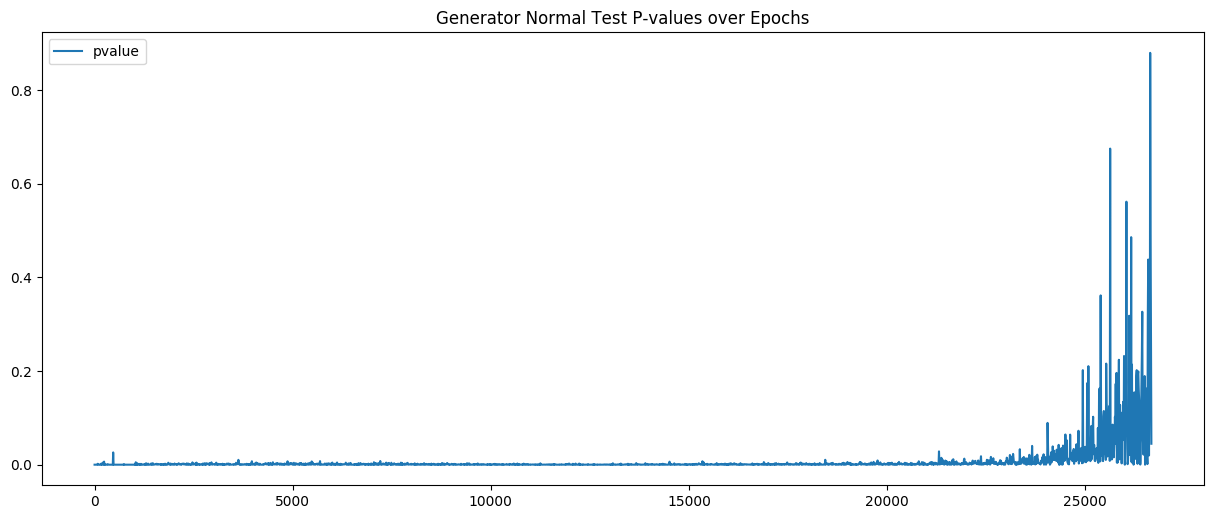

In [307]:

fig = plt.figure()
    
plot_samples = range(0, len(df_metadata)+1, 10)

plt.plot(plot_samples, df_metadata['d_fake_data_pvalue'].iloc[plot_samples], label='pvalue')

plt.title("Generator Normal Test P-values over Epochs")
plt.legend()
plt.show()

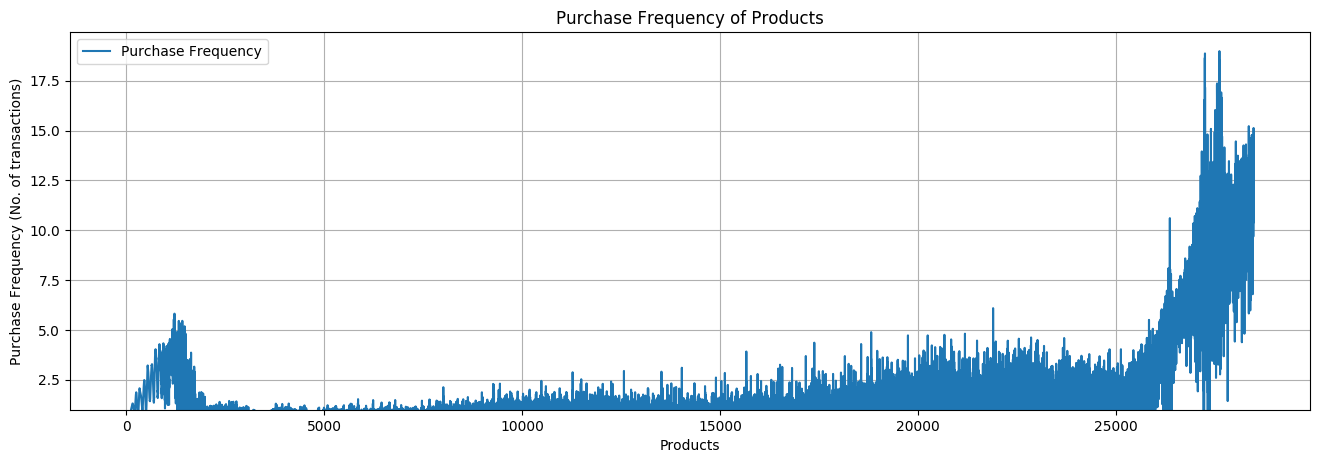

In [291]:
fig = plt.figure()

#fig.patch.set_facecolor('white')

# just to get rid of the indices, so that we could plot the result easier.
dist = pd.Series(g_error_list,
                 name='Purchase Frequency')

ax = dist.plot(kind='line', logy=False, grid=True,
               ylim=True,
               #color='r',
               figsize=(16, 5), legend=True,
               title="Purchase Frequency of Products")

#ax.axvline(65500, color='darkblue', linestyle='-')
#ax.axhline(10, color='darkgreen', linestyle='-')

plt.xlabel("Products")
plt.ylabel("Purchase Frequency (No. of transactions)")
plt.show()

### Validation

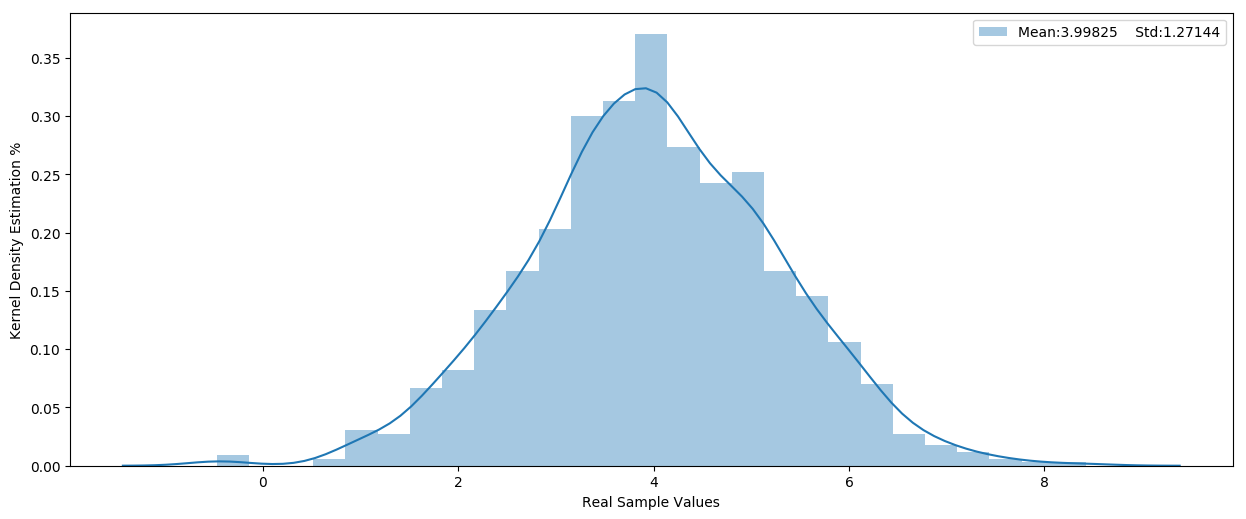

In [435]:

input_samples = d_sampler(1000).numpy()[0]

def plot_kde(input_samples, xlabel):

    legend = "Mean:" + str(input_samples.mean()) + \
             "    Std:" + str(input_samples.std())

    ax = sns.distplot(input_samples, kde=True, label=legend, axlabel=xlabel)
    ax.set_ylabel("Kernel Density Estimation %")
    _ = ax.legend()


#plot_kde_game(input_samples, g_fake_data)
    
plot_kde(input_samples, 'Real Sample Values')

Text(0,0.5,'count')

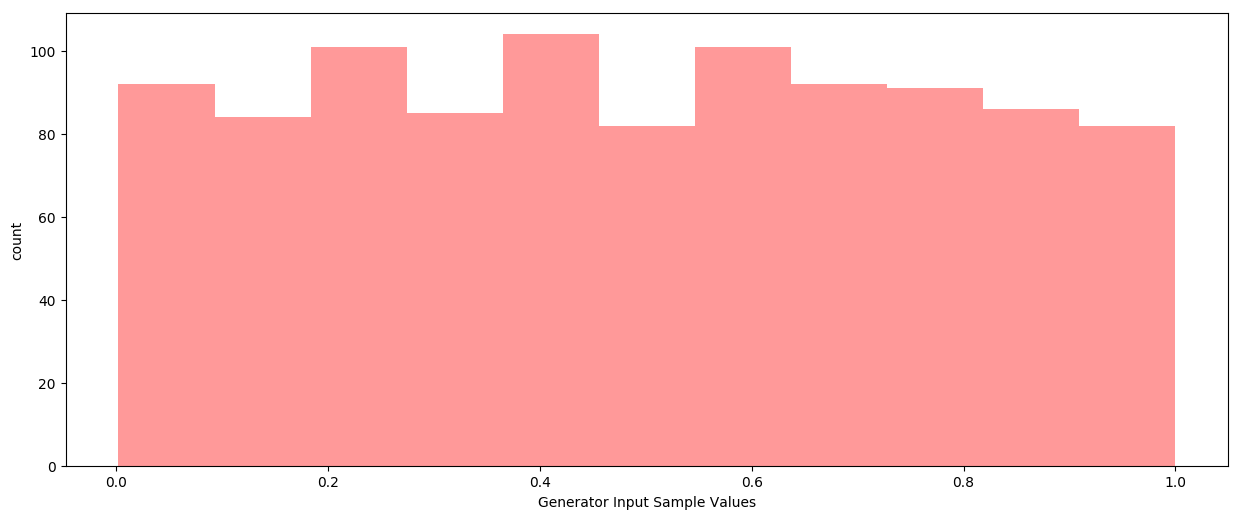

In [439]:
generator_input_samples = gi_sampler(1000, g_input_size)


ax = sns.distplot(generator_input_samples.numpy(), hist=True, kde=False, color='r')
ax.set_xlabel('Generator Input Sample Values')
ax.set_ylabel('count')


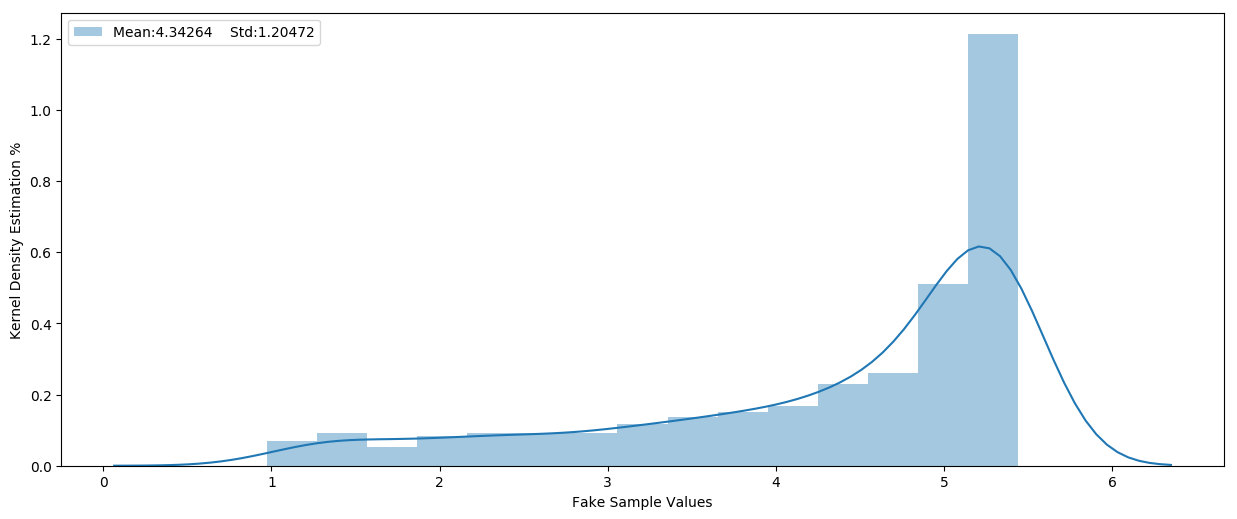

In [440]:
 
gen_input = Variable(generator_input_samples).cuda()

g_fake_data = G(gen_input).t().data.cpu().numpy()

plot_kde(g_fake_data, xlabel='Fake Sample Values')

#dg_fake_decision = D(preprocess(g_fake_data.t()))

            